# **KM Master Discrepancy Detection System - Analysis**

![Python Code](https://img.shields.io/badge/Python-Code-blue?logo=python&logoColor=white)
![Sheets API](https://img.shields.io/badge/Google_Sheets-API-34A853?logo=googlesheets&logoColor=white)

### **Project Context**

KM Master represents the **round-trip distance** between Operating Points (OP) and Stores, which is critical for calculating **UJP** (Uang Jalan Pengiriman - transportation costs).

**Why This Matters:**
- **Underestimated distances** → Operational problems, driver dissatisfaction
- **Overestimated distances** → Fraud opportunities, inflated costs

With **thousands of stores**, manually validating all KM Master entries is impractical. The operations team needs to **prioritize** which entries to validate first.

# **Setup and Libraries**

In [1]:
# setup source path
import sys
import os

# add source directory to python path for custom modules
src_path = os.path.join(os.getcwd(), "..", "src")

if src_path not in sys.path:
    sys.path.append(src_path)
    print(f"Added {src_path[34:]} to sys.path")
else:
    print(f"{src_path[34:]} already in sys.path")

Added km-master-discrepancy-detection-system\notebooks\..\src to sys.path


In [2]:
# initialize configuration and environment variables
import config
from dotenv import load_dotenv
load_dotenv(config.ENV_PATH)

# set hide_values parameter
# config.HIDE_VALUES = False  # uncomment to show numeric values

# import custom modules
from google_sheets_io import sheets_loader, sheets_updater
from utils import (setup_logging, mask_numeric_value, DataTracker, result_summary, 
                   plot_outlier, filter_iqr, pivot_and_remove_low_freq_stores,
                   get_unique_stores, get_diff_unique_stores)

# import common libraries
import pandas as pd
import numpy as np
import logging
import time
import re

pd.set_option('future.no_silent_downcasting', True) # to suppress warning messages

# setup logging
setup_logging()
logger = logging.getLogger(__name__)

# display configuration
if config.HIDE_VALUES:
    logger.info(f"Hiding numeric values with '*' symbol")
else:
    logger.info("Showing numeric values")

2025-12-16 06:41:47 - __main__ - INFO - Hiding numeric values with '*' symbol


# **Data**

This notebook using data result from 01-Data-Preprocessing.ipynb

### **Key Columns:**
  - `Tgl SLA` - Delivery date
  - `Nomor SPJ` - Delivery records / Waybill. One `SPJ` may contain several `Toko`
  - `OP` - Operating Point Code
  - `Toko` - Store code
  - `KM Master` - Master distance (round-trip) for each `Toko`
  - `KM Tempuh` - Actual distance traveled (round-trip) for each `SPJ`
  - `KM Max` - Maximum value of `KM Master` for each `SPJ`
  - `KM Deviation (%)` - Deviation value between `KM Tempuh` and `KM Master` in %
  - `Kode Zona` - Zone code
  - `Kecamatan`, `Kota`, `Provinsi` - Geographic info

<br>

> **Disclaimer:** <br>Due to confidentiality, actual data **is not included** in this repository. <br>Some values are replaced with the `*` symbol.

<br>

> **Notes:** <br>For convenience, this project will using term **Unique Store** to label unique `OP` and `Toko` combination

In [3]:
# define path for all data
all_data_path = os.path.join(config.DATA_PATH, "clean", "df_all_data.csv")

# read all data
start_time = time.time()
df_all_data = pd.read_csv(all_data_path)
load_time = time.time() - start_time

logger.info(f"Loaded {mask_numeric_value(f'{len(df_all_data[['OP','Toko']].drop_duplicates()):,}')} unique stores of all data in {load_time:.2f} secs")

2025-12-16 06:41:54 - __main__ - INFO - Loaded **,*** unique stores of all data in 6.99 secs


# **KM Master Method**

Explain method

In [4]:
# track KM Master method
tracker_km_master = DataTracker("KM Master Method")
tracker_km_master.track(df_all_data, step_name="Initial Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:41:54 - utils - INFO - Initialized DataTracker for: [KM Master Method]
2025-12-16 06:41:55 - utils - INFO - [KM Master Method] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


## **A. Main Method**

In [5]:
# get data with KM Master outside or equal to treshold for giving recommendation
min_km_master = 1
max_km_master = 1800
df_km_master = df_all_data[(df_all_data['KM Master'] < min_km_master) | (df_all_data['KM Master'] > max_km_master)]

# drop duplicate rows and sort based on OP and Toko
df_km_master = df_km_master.drop_duplicates(subset=['OP', 'Toko']).sort_values(by=['OP', 'Toko']).reset_index(drop=True)

# only keep relevant columns
df_km_master = df_km_master[['OP', 'Kode Zona', 'Toko', 'KM Master']]

# add recommendation column
df_km_master['KM Master Rekomendasi'] = np.nan

tracker_km_master.track(df_km_master, step_name="Remove KM Master Outside Treshold", rows_unique=['OP', 'Toko'])

2025-12-16 06:41:55 - utils - INFO - [KM Master Method] Step: Remove KM Master Outside Treshold | Counts: * | Change: -**,*** (-99.99%) | Retention: 0.01% | Step Time: 0.60s | Cumulative Time: 0.60s


In [6]:
# get data from google sheets for recommendation
worksheet = sheets_loader(sheets_url=os.getenv('SHEETS_URL')).worksheet(config.UPDATED_WORKSHEET)
df_recommendation = pd.DataFrame(worksheet.get_all_records())
df_recommendation = df_recommendation.replace("", np.nan).infer_objects(copy=False)
logger.info(f"Loaded {mask_numeric_value(f'{len(df_recommendation):,}')} rows of google sheets recommendation data")

# check if google sheet data is empty
if df_recommendation.empty:
    df_recommendation = pd.DataFrame(columns=['OP', 'Kode Zona', 'Toko', 'KM Master Rekomendasi'])

# check the data
check_content = df_km_master[['OP', 'Kode Zona', 'Toko']].isin(df_recommendation[['OP', 'Kode Zona', 'Toko']]).all().all()
check_recommendation = df_recommendation['KM Master Rekomendasi'].isna().sum()

if check_content: # if df_km_master content is in df_recommendation
    if check_recommendation > 0: # if there is OP and Store with no recommendation
        # update google sheet data with no KM Master recommendation
        df_km_master = df_km_master.where(df_km_master.notna(), "")
        sheets_updater(sheets_url=os.getenv('SHEETS_URL'), df=df_km_master)
        logger.warning(f"Update {config.UPDATED_WORKSHEET} with no KM Master recommendation")
        # hide values if configured
        if config.HIDE_VALUES:
            raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')[:30]} [Redacted]")
        else:
            raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')}")
    else:
        logger.info(f"Data in {config.UPDATED_WORKSHEET} is completed")
else:
    # update google sheet data with no KM Master recommendation
    df_km_master = df_km_master.where(df_km_master.notna(), "")
    sheets_updater(sheets_url=os.getenv('SHEETS_URL'), df=df_km_master)
    logger.warning(f"Update {config.UPDATED_WORKSHEET} with no KM Master recommendation")
    # hide values if configured
    if config.HIDE_VALUES:
        raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')[:30]} [Redacted]")
    else:
        raise ValueError(f"Give recommendation to {config.UPDATED_WORKSHEET} in URL: {os.getenv('SHEETS_URL')}")

tracker_km_master.track(df_recommendation, step_name="Give KM Master Recommendation", rows_unique=['OP', 'Toko'])

2025-12-16 06:41:55 - google_sheets_io - INFO - Loading Google Sheets from URL: https://docs.google.com/spread [Redacted]...
2025-12-16 06:41:55 - google_sheets_io - INFO - Credentials loaded successfully
2025-12-16 06:41:55 - google_sheets_io - INFO - Google Sheets API authorized
2025-12-16 06:41:56 - google_sheets_io - INFO - Sheet opened successfully
2025-12-16 06:41:57 - __main__ - INFO - Loaded * rows of google sheets recommendation data
2025-12-16 06:41:57 - __main__ - INFO - Data in Rekomendasi Manual KM Master is completed
2025-12-16 06:41:57 - utils - INFO - [KM Master Method] Step: Give KM Master Recommendation | Counts: * | Change: +0 (+0.00%) | Retention: 0.01% | Step Time: 2.00s | Cumulative Time: 2.60s


> **Notes:** <br>If there is no recommendation or different data for KM Master method in google sheet, it will give error and need to get recommendation based on manual works. For example, you may look at this picture:

![pict](../img/km_master_method_fail_example_v2.png)

## **B. KM Master Result**

In [7]:
# save the result
df_km_master_final = df_recommendation.copy()
unique_store_km_master = df_km_master_final[['OP', 'Toko']].drop_duplicates()

# format data
df_km_master_final['Metode'] = 'KM Master'
df_km_master_final = df_km_master_final.rename(columns={'KM Master': 'KM Master Saat Ini'})
df_km_master_final = df_km_master_final[['OP', 'Kode Zona', 'Toko', 'KM Master Saat Ini', 'KM Master Rekomendasi', 'Metode']]

tracker_km_master.track(df_km_master_final, step_name="Final Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:41:57 - utils - INFO - [KM Master Method] Step: Final Unique Store | Counts: * | Change: +0 (+0.00%) | Retention: 0.01% | Step Time: 0.02s | Cumulative Time: 2.62s


In [8]:
# show summary
tracker_km_master.summary()

2025-12-16 06:41:57 - utils - INFO - [KM Master Method] DataTracker summary generated for 4 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Remove KM Master Outside Treshold,*,"-**,***",-99.99,0.01,0.60,0.60
2,Give KM Master Recommendation,*,+0,+0.00,0.01,2.00,2.60
3,Final Unique Store,*,+0,+0.00,0.01,0.02,2.62


# **KM Tempuh Method**

Explain method

In [9]:
# track KM Tempuh method
tracker_km_tempuh = DataTracker("KM Tempuh Method")
tracker_km_tempuh.track(df_all_data, step_name="Initial Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:41:57 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method]
2025-12-16 06:41:58 - utils - INFO - [KM Tempuh Method] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


In [10]:
# load data exclude unique store from km master method
df_km_tempuh = (
    df_all_data
    .merge(unique_store_km_master, on=['OP', 'Toko'], how='left', indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)

In [11]:
# separate df_km_tempuh into two data category

# data with km max = 1 (C1)
df_km_tempuh_c1 = df_km_tempuh[df_km_tempuh['KM Max'] == 1]

# data with km max <> 1 (C2)
df_km_tempuh_c2 = df_km_tempuh[df_km_tempuh['KM Max'] != 1]

Explain there is still intersect of unique store betwwen two dataset category and we need to remove

In [12]:
# search intersect of unique store between two data category
unique_store_c1 = df_km_tempuh_c1[['OP', 'Toko']].drop_duplicates()
unique_store_c2 = df_km_tempuh_c2[['OP', 'Toko']].drop_duplicates()
intersect_unique_store_c1_c2 = pd.merge(
                                  unique_store_c1,
                                  unique_store_c2,
                                  on=['OP', 'Toko'],
                                  how='inner'
                                  )

# remove df_km_tempuh_c2 from intersect data
df_km_tempuh_c2 = (
    df_km_tempuh_c2
    .merge(intersect_unique_store_c1_c2, on=['OP', 'Toko'], how='left', indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=['_merge'])
)

# save unique store of KM Tempuh and C2 data for validate
unique_store_km_tempuh = df_km_tempuh[['OP', 'Toko']].drop_duplicates()
unique_store_c2 = df_km_tempuh_c2[['OP', 'Toko']].drop_duplicates()

# validate data
if len(intersect_unique_store_c1_c2) == 0:
    logger.info("No intersect unique store between two data category")
else:
  if len(unique_store_c1) + len(unique_store_c2) == len(unique_store_km_tempuh):
    logger.info("Total data is appropriate. Separation data is success!")
  else:
    logger.error("Total data doesn't match. Separation data is failed.")

2025-12-16 06:42:07 - __main__ - INFO - Total data is appropriate. Separation data is success!


## **A. KM Max = 1 Category**

In [13]:
# track KM Tempuh C1 method
tracker_km_tempuh_c1 = DataTracker("KM Tempuh Method (KM Max = 1)")
tracker_km_tempuh_c1.track(df_km_tempuh_c1, step_name="Initial Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:07 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method (KM Max = 1)]
2025-12-16 06:42:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Initial Unique Store | Counts: *** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


### **1. Remove Outlier**

2025-12-16 06:42:07 - utils - INFO - Plotting outlier detection for 'KM Tempuh Method (KM Max = 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max = 1)'
2025-12-16 06:42:07 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=1.5, upper=1.5
2025-12-16 06:42:07 - utils - INFO - IQR filter applied on 'KM Deviation (%)': * rows removed (0.06%)


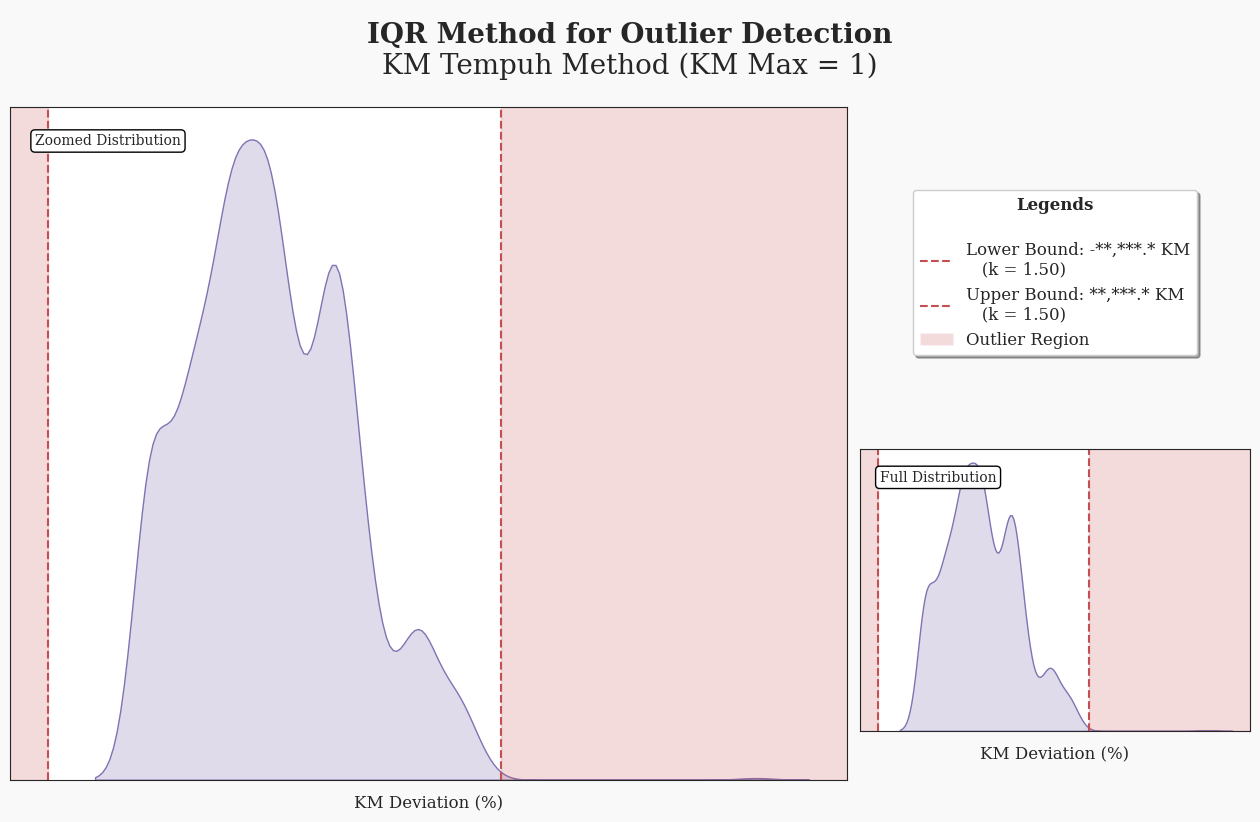

2025-12-16 06:42:07 - utils - INFO - Outlier detection plot generated for 'KM Tempuh Method (KM Max = 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max = 1)'


In [14]:
# show outlier plot to determine treshold for KM Tempuh C1 method
plot_outlier(df=df_km_tempuh_c1, name="KM Tempuh Method (KM Max = 1)")

Give explain about the plot

In [15]:
# remove outlier using IQR method
df_km_tempuh_c1_xoutlier = filter_iqr(df_km_tempuh_c1)[0]

tracker_km_tempuh_c1.track(df_km_tempuh_c1_xoutlier, step_name="Remove Outlier", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:07 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=1.5, upper=1.5
2025-12-16 06:42:07 - utils - INFO - IQR filter applied on 'KM Deviation (%)': * rows removed (0.06%)
2025-12-16 06:42:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Remove Outlier | Counts: *** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.35s | Cumulative Time: 0.35s


### **2. Remove Correct Store**

In [16]:
# remove correct store based on operational knowledge
df_km_tempuh_c1_xoutlier_xcorrect = df_km_tempuh_c1_xoutlier[df_km_tempuh_c1_xoutlier['KM Deviation (%)'].abs() > config.RIGHT_DEV_KM_TRESHOLD].copy()

logger.info(f"Removed correct store with treshold {config.RIGHT_DEV_KM_TRESHOLD}% of KM Deviation")

tracker_km_tempuh_c1.track(df_km_tempuh_c1_xoutlier_xcorrect, step_name="Remove Correct Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:07 - __main__ - INFO - Removed correct store with treshold 3.0% of KM Deviation
2025-12-16 06:42:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Remove Correct Store | Counts: *** | Change: -* (-2.59%) | Retention: 97.41% | Step Time: 0.01s | Cumulative Time: 0.36s


Explain why 3% using BBM Ratio with Rp6800 per liter

### **3. Pivot and Remove Low-Frequency Stores**

In [17]:
# pivot and remove store with low-frequency visits
df_km_tempuh_c1_pivot = pivot_and_remove_low_freq_stores(
                                            df=df_km_tempuh_c1_xoutlier_xcorrect
                                            )

tracker_km_tempuh_c1.track(df_km_tempuh_c1_pivot, step_name="Pivot & Remove Low-Frequency Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:07 - utils - INFO - Pivot table created: *** unique stores
2025-12-16 06:42:07 - utils - INFO - After removing low-frequency stores with frequency <= 1: *** unique stores
2025-12-16 06:42:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Pivot & Remove Low-Frequency Store | Counts: *** | Change: -*** (-40.86%) | Retention: 57.61% | Step Time: 0.03s | Cumulative Time: 0.39s


### **4. Finalize Data & Summary**

In [18]:
# remove if there are KM Tempuh equal to KM Master because of rounding
# it is because mean of KM Tempuh will be KM Master Recommendation
df_km_tempuh_c1_final = df_km_tempuh_c1_pivot[~(df_km_tempuh_c1_pivot['KM Tempuh'] == df_km_tempuh_c1_pivot['KM Master'])]

tracker_km_tempuh_c1.track(df_km_tempuh_c1_final, step_name="Final Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] Step: Final Unique Store | Counts: *** | Change: +0 (+0.00%) | Retention: 57.61% | Step Time: 0.01s | Cumulative Time: 0.40s


In [19]:
# show summary
tracker_km_tempuh_c1.summary()

2025-12-16 06:42:07 - utils - INFO - [KM Tempuh Method (KM Max = 1)] DataTracker summary generated for 5 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,***,+0,+0.00,100.00,0.00,0.00
1,Remove Outlier,***,+0,+0.00,100.00,0.35,0.35
2,Remove Correct Store,***,-*,-2.59,97.41,0.01,0.36
3,Pivot & Remove Low-Frequency Store,***,-***,-40.86,57.61,0.03,0.39
4,Final Unique Store,***,+0,+0.00,57.61,0.01,0.40


## **B. KM Max <> 1 Category**

In [20]:
# track KM Tempuh C2 method
tracker_km_tempuh_c2 = DataTracker("KM Tempuh Method (KM Max <> 1)")
tracker_km_tempuh_c2.track(df_km_tempuh_c2, step_name="Initial Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:07 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method (KM Max <> 1)]
2025-12-16 06:42:08 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


### **1. Remove KM Max <> KM Master**

In [21]:
# remove KM Max is not equal to KM Master
df_km_tempuh_c2_max = df_km_tempuh_c2[df_km_tempuh_c2['KM Max'] == df_km_tempuh_c2['KM Master']].copy()

tracker_km_tempuh_c2.track(df_km_tempuh_c2_max, step_name="Remove KM Max is not equal to KM Master", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:08 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] Step: Remove KM Max is not equal to KM Master | Counts: **,*** | Change: -**,*** (-38.06%) | Retention: 61.94% | Step Time: 0.84s | Cumulative Time: 0.84s


### **2. Remove Outlier**

2025-12-16 06:42:08 - utils - INFO - Plotting outlier detection for 'KM Tempuh Method (KM Max <> 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max <> 1)'
2025-12-16 06:42:08 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=2, upper=9
2025-12-16 06:42:08 - utils - INFO - IQR filter applied on 'KM Deviation (%)': **,*** rows removed (3.37%)


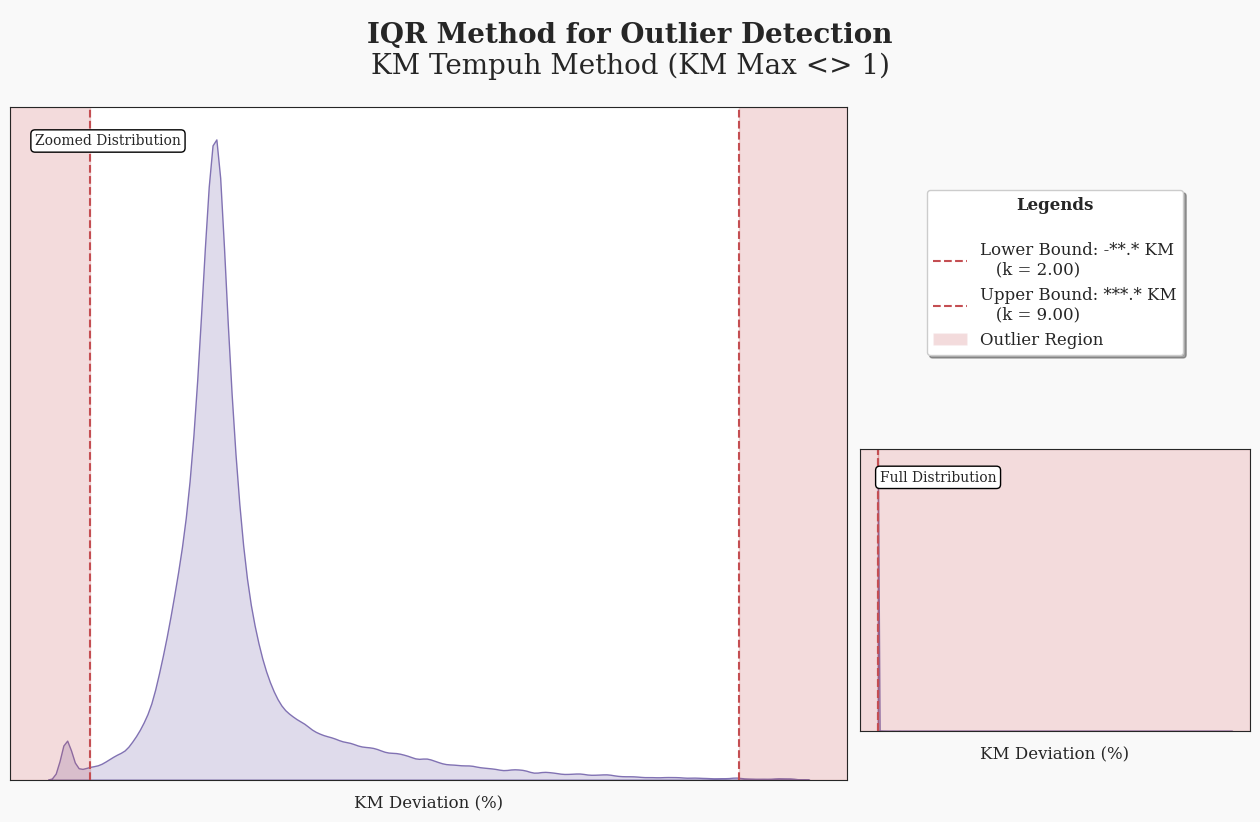

2025-12-16 06:42:25 - utils - INFO - Outlier detection plot generated for 'KM Tempuh Method (KM Max <> 1)' on column 'KM Deviation (%)' for 'KM Tempuh Method (KM Max <> 1)'


In [22]:
# show outlier plot to determine treshold for KM Tempuh C1 method
plot_outlier(
        df=df_km_tempuh_c2_max, 
        name="KM Tempuh Method (KM Max <> 1)", 
        lower_constant=2, upper_constant=9
        )

In [23]:
# remove outlier using IQR method
df_km_tempuh_c2_max_xoutlier = filter_iqr(df_km_tempuh_c2_max, lower_constant=2, upper_constant=9)[0]

tracker_km_tempuh_c2.track(df_km_tempuh_c2_max_xoutlier, step_name="Remove Outlier", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:25 - utils - INFO - Applying IQR filter on column 'KM Deviation (%)' with constants: lower=2, upper=9
2025-12-16 06:42:25 - utils - INFO - IQR filter applied on 'KM Deviation (%)': **,*** rows removed (3.37%)
2025-12-16 06:42:26 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] Step: Remove Outlier | Counts: **,*** | Change: -*** (-2.88%) | Retention: 60.16% | Step Time: 17.43s | Cumulative Time: 18.27s


### **3. Remove Correct Store**

In [24]:
# remove correct store based on operational knowledge
df_km_tempuh_c2_max_xoutlier_xcorrect = df_km_tempuh_c2_max_xoutlier[df_km_tempuh_c2_max_xoutlier['KM Deviation (%)'].abs() > config.RIGHT_DEV_KM_TRESHOLD].copy()

logger.info(f"Removed correct store with treshold {config.RIGHT_DEV_KM_TRESHOLD}% of KM Deviation")

tracker_km_tempuh_c2.track(df_km_tempuh_c2_max_xoutlier_xcorrect, step_name="Remove Correct Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:26 - __main__ - INFO - Removed correct store with treshold 3.0% of KM Deviation
2025-12-16 06:42:26 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] Step: Remove Correct Store | Counts: **,*** | Change: -*** (-1.48%) | Retention: 59.27% | Step Time: 0.40s | Cumulative Time: 18.67s


### **4. Pivot and Remove Low-Frequency Stores**

In [25]:
# pivot and remove store with low-frequency visits
df_km_tempuh_c2_pivot = pivot_and_remove_low_freq_stores(
                                        df=df_km_tempuh_c2_max_xoutlier_xcorrect
                                        )

tracker_km_tempuh_c2.track(df_km_tempuh_c2_pivot, step_name="Pivot & Remove Low-Frequency Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:26 - utils - INFO - Pivot table created: **,*** unique stores
2025-12-16 06:42:26 - utils - INFO - After removing low-frequency stores with frequency <= 1: **,*** unique stores
2025-12-16 06:42:26 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] Step: Pivot & Remove Low-Frequency Store | Counts: **,*** | Change: -*,*** (-11.28%) | Retention: 52.58% | Step Time: 0.63s | Cumulative Time: 19.29s


### **5. Finalize Data & Summary**

In [26]:
# remove if there are KM Tempuh equal to KM Master because of rounding
# it is because mean of KM Tempuh will be KM Master Recommendation
df_km_tempuh_c2_final = df_km_tempuh_c2_pivot[~(df_km_tempuh_c2_pivot['KM Tempuh'] == df_km_tempuh_c2_pivot['KM Master'])]

tracker_km_tempuh_c2.track(df_km_tempuh_c2_final, step_name="Final Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:27 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] Step: Final Unique Store | Counts: **,*** | Change: -*** (-2.58%) | Retention: 51.22% | Step Time: 0.02s | Cumulative Time: 19.31s


In [27]:
# show summary
tracker_km_tempuh_c2.summary()

2025-12-16 06:42:27 - utils - INFO - [KM Tempuh Method (KM Max <> 1)] DataTracker summary generated for 6 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Remove KM Max is not equal to KM Master,"**,***","-**,***",-38.06,61.94,0.84,0.84
2,Remove Outlier,"**,***",-***,-2.88,60.16,17.43,18.27
3,Remove Correct Store,"**,***",-***,-1.48,59.27,0.40,18.67
4,Pivot & Remove Low-Frequency Store,"**,***","-*,***",-11.28,52.58,0.63,19.29
5,Final Unique Store,"**,***",-***,-2.58,51.22,0.02,19.31


## **C. Outlier Category**

In [28]:
# get outlier data from both category

# C1 outlier data
mask_c1_outlier = ~df_km_tempuh_c1.set_index(['OP', 'Toko']).index.isin(df_km_tempuh_c1_xoutlier.set_index(['OP', 'Toko']).index)  
df_km_tempuh_c1_outlier = df_km_tempuh_c1[mask_c1_outlier].copy()

# C2 outlier data
mask_c2_outlier = ~df_km_tempuh_c2_max.set_index(['OP', 'Toko']).index.isin(df_km_tempuh_c2_max_xoutlier.set_index(['OP', 'Toko']).index)
df_km_tempuh_c2_outlier = df_km_tempuh_c2_max[mask_c2_outlier].copy()

# concat outlier data
df_km_tempuh_outlier = pd.concat([df_km_tempuh_c1_outlier, df_km_tempuh_c2_outlier], ignore_index=True)

In [29]:
# track outlier data
tracker_km_tempuh_outlier = DataTracker("KM Tempuh Method (Outlier)")
tracker_km_tempuh_outlier.track(df_km_tempuh_outlier, step_name="Outlier Data", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:27 - utils - INFO - Initialized DataTracker for: [KM Tempuh Method (Outlier)]
2025-12-16 06:42:27 - utils - INFO - [KM Tempuh Method (Outlier)] Step: Outlier Data | Counts: *** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


### **1. Pivot and Remove Low-Frequency Stores**

In [30]:
# pivot and remove store with low-frequency visits
df_km_tempuh_outlier_pivot = pivot_and_remove_low_freq_stores(
                                        df=df_km_tempuh_outlier,
                                        count_toko=3 # use more strict treshold for outlier data
                                        )

tracker_km_tempuh_outlier.track(df_km_tempuh_outlier_pivot, step_name="Pivot & Remove Low-Frequency Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:27 - utils - INFO - Pivot table created: *** unique stores
2025-12-16 06:42:27 - utils - INFO - After removing low-frequency stores with frequency <= 3: *** unique stores
2025-12-16 06:42:27 - utils - INFO - [KM Tempuh Method (Outlier)] Step: Pivot & Remove Low-Frequency Store | Counts: *** | Change: -*** (-81.21%) | Retention: 18.79% | Step Time: 0.03s | Cumulative Time: 0.04s


### **2. Finalize Data & Summary**

In [31]:
# remove if there are KM Tempuh equal to KM Master because of rounding
# it is because mean of KM Tempuh will be KM Master Recommendation
df_km_tempuh_outlier_final = df_km_tempuh_outlier_pivot[~(df_km_tempuh_outlier_pivot['KM Tempuh'] == df_km_tempuh_outlier_pivot['KM Master'])]

tracker_km_tempuh_outlier.track(df_km_tempuh_outlier_final, step_name="Final Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:27 - utils - INFO - [KM Tempuh Method (Outlier)] Step: Final Unique Store | Counts: *** | Change: +0 (+0.00%) | Retention: 18.79% | Step Time: 0.01s | Cumulative Time: 0.05s


In [32]:
# show summary
tracker_km_tempuh_outlier.summary()

2025-12-16 06:42:27 - utils - INFO - [KM Tempuh Method (Outlier)] DataTracker summary generated for 3 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Outlier Data,***,+0,+0.00,100.00,0.00,0.00
1,Pivot & Remove Low-Frequency Store,***,-***,-81.21,18.79,0.03,0.04
2,Final Unique Store,***,+0,+0.00,18.79,0.01,0.05


## **D. KM Tempuh Result**

In [33]:
# concat final data from KM Tempuh C1, C2, and Outlier
df_km_tempuh_final = pd.concat(
    [df_km_tempuh_c1_final, df_km_tempuh_c2_final, df_km_tempuh_outlier_final],
    ignore_index=True
    )

# format dataframe
df_km_tempuh_final.rename(columns={'KM Tempuh': 'KM Master Rekomendasi',
                                   'KM Master': 'KM Master Saat Ini'}, inplace=True)
df_km_tempuh_final.drop(columns=['Freq Toko'], inplace=True)
df_km_tempuh_final = df_km_tempuh_final[['OP', 'Kode Zona', 'Toko', 'KM Master Rekomendasi', 'KM Master Saat Ini']]
df_km_tempuh_final['Metode'] = 'KM Tempuh'

# check if there are duplicate unique store
if df_km_tempuh_final.duplicated(subset=['OP', 'Toko']).any():
    logger.exception("There are duplicate unique store in final KM Tempuh data")
    raise ValueError("There are duplicate unique store in final KM Tempuh data")

# save processed unique store list for next method
# km tempuh method result unique stores
list_unique_store_km_tempuh = get_unique_stores(df_km_tempuh_final)
# correct unique stores from each category
list_unique_store_c1_correct = get_diff_unique_stores(df_km_tempuh_c1_xoutlier, df_km_tempuh_c1_xoutlier_xcorrect)
list_unique_store_c2_correct = get_diff_unique_stores(df_km_tempuh_c2_max_xoutlier, df_km_tempuh_c2_max_xoutlier_xcorrect)
# identical km master recommendation with current km master unique stores
list_unique_store_c1_identical = get_diff_unique_stores(df_km_tempuh_c1_pivot, df_km_tempuh_c1_final)
list_unique_store_c2_identical = get_diff_unique_stores(df_km_tempuh_c2_pivot, df_km_tempuh_c2_final)
list_unique_store_outlier_identical = get_diff_unique_stores(df_km_tempuh_outlier_pivot, df_km_tempuh_outlier_final)
# combine result
list_unique_store_km_tempuh_processed = (
                    list_unique_store_km_tempuh + 
                    list_unique_store_c1_correct + list_unique_store_c2_correct + 
                    list_unique_store_c1_identical + list_unique_store_c2_identical + list_unique_store_outlier_identical
                    )

tracker_km_tempuh.track(df_km_tempuh_final, step_name="Final Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:28 - utils - INFO - [KM Tempuh Method] Step: Final Unique Store | Counts: **,*** | Change: -**,*** (-48.41%) | Retention: 51.59% | Step Time: 30.87s | Cumulative Time: 30.87s


In [34]:
# show summary
tracker_km_tempuh.summary()

2025-12-16 06:42:28 - utils - INFO - [KM Tempuh Method] DataTracker summary generated for 2 steps.


,Step,Counts,Change,Change (%),Retained (%),Duration (s),Cumulative Time (s)
0,Initial Unique Store,"**,***",+0,+0.00,100.00,0.00,0.00
1,Final Unique Store,"**,***","-**,***",-48.41,51.59,30.87,30.87


# **Master Zona Method**

Explain method

In [35]:
# track Master Zona method
tracker_master_zona = DataTracker("Master Zona Method")
tracker_master_zona.track(df_all_data, step_name="Initial Unique Store", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:28 - utils - INFO - Initialized DataTracker for: [Master Zona Method]
2025-12-16 06:42:29 - utils - INFO - [Master Zona Method] Step: Initial Unique Store | Counts: **,*** | Change: +0 (+0.00%) | Retention: 100.00% | Step Time: 0.00s | Cumulative Time: 0.00s


Explain why we need to filter based on Provinsi because there are province with different route schema like more longer distance, road infrastructure is still not efficient, etc

In [36]:
# filter using 'Provinsi' to analyze data with similar condition
list_province = os.getenv('MASTER_ZONA_PROVINCES').split(',')
df_master_zona = df_all_data[df_all_data['Provinsi'].isin(list_province)].copy()

tracker_master_zona.track(df_master_zona, step_name="Filter by Province", rows_unique=['OP', 'Toko'])

2025-12-16 06:42:30 - utils - INFO - [Master Zona Method] Step: Filter by Province | Counts: **,*** | Change: -*,*** (-13.09%) | Retention: 86.91% | Step Time: 1.33s | Cumulative Time: 1.34s


## Main Method

## Master Zona Result

# Results Summary